In [1]:
import sys
sys.path.insert(0, '../../Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
np.random.seed(1232)
tf.set_random_seed(1232)

In [3]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, uend,tb, X_f, layers, lb, ub,u_lb,u_ub):
        
        #    lb = np.array([0, 0])      ub = np.array([1, 1])
        
        X0 = np.concatenate((x0, 0*x0), 1)              #    初始  
        X1 = np.concatenate((x0, 0*x0+1), 1) 
        X_lb = np.concatenate((0*tb + lb[0], tb), 1)    #    边界0
        X_ub = np.concatenate((0*tb + ub[0], tb), 1)    #    边界1    
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]
   
        self.t1 = X1[:,1:2]
        
        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        
        self.x_f1 = X_f[:,0:1]
        self.t_f1 = X_f[:,1:2]*1/10*4      
        
        self.x_f2 = X_f[:,0:1]
        self.t_f2 = X_f[:,1:2]*1/10*4+0.2         
        
        self.x_f3 = X_f[:,0:1]
        self.t_f3 = X_f[:,1:2]*1/10*4+0.6   
        
        
        
        
        self.u_lb=u_lb
        self.u_ub=u_ub
        #分别是初始时刻的实部和虚部
        self.u0 = u0
        self.uend = uend
        self.losslossloss=[]
        # Initialize NNs
        self.layers = layers
        
        self.loss1weight=1
        self.loss2weight=1
        #返回初始的权重w和偏差b
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf Placeholders
        #形参 占位符，行数不确定，列数确定为1
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        self.t1_tf = tf.placeholder(tf.float32, shape=[None, self.t1.shape[1]])        
        self.u_lb_tf = tf.placeholder(tf.float32, shape=[None, self.u_lb.shape[1]])
        self.u_ub_tf = tf.placeholder(tf.float32, shape=[None, self.u_ub.shape[1]])
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])
        self.uend_tf = tf.placeholder(tf.float32, shape=[None, self.uend.shape[1]])                
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])

        
        
        self.x_f1_tf = tf.placeholder(tf.float32, shape=[None, self.x_f1.shape[1]])
        self.t_f1_tf = tf.placeholder(tf.float32, shape=[None, self.t_f1.shape[1]])        
        self.x_f2_tf = tf.placeholder(tf.float32, shape=[None, self.x_f1.shape[1]])
        self.t_f2_tf = tf.placeholder(tf.float32, shape=[None, self.t_f1.shape[1]])      
        self.x_f3_tf = tf.placeholder(tf.float32, shape=[None, self.x_f1.shape[1]])
        self.t_f3_tf = tf.placeholder(tf.float32, shape=[None, self.t_f1.shape[1]])            
        
        
      
        self.f_u1_pred= self.net_f_uv(self.x_f1_tf, self.t_f1_tf)
        self.f_u2_pred= self.net_f_uv(self.x_f2_tf, self.t_f2_tf)
        self.f_u3_pred= self.net_f_uv(self.x_f3_tf, self.t_f3_tf)         
        # tf Graphs  进行预测
        self.u0_pred= self.net_uv(self.x0_tf, self.t0_tf)
        self.uend_pred= self.net_uv(self.x0_tf, self.t1_tf)
        self.u_lb_pred= self.net_uv(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred = self.net_uv(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred= self.net_f_uv(self.x_f_tf, self.t_f_tf)
        self.hsadasjd=1
        

        
        
        self.loss111 = tf.pow((tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))),1)       
        
        self.loss222 =tf.pow(tf.reduce_mean(tf.square(self.f_u_pred)),1)      

        self.loss21=tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1/1)
        self.loss22=tf.pow(tf.reduce_mean(tf.square(self.f_u2_pred)),1/1)
        self.loss23=tf.pow(tf.reduce_mean(tf.square(self.f_u3_pred)),1/1)             
        
        

        self.loss = (tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1/2)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u2_pred)),1/4)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u3_pred)),1/2)            
            
        self.LOSSloss1 = (tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u2_pred)),1/3)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u3_pred)),1)             
            

        self.LOSSloss2 = (tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u2_pred)),1/2)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u3_pred)),1)              
            
        self.LOSSloss3 = (tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                    tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))) +\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u1_pred)),1)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u2_pred)),1)+\
                    tf.pow(tf.reduce_mean(tf.square(self.f_u3_pred)),1)              
            
            
        # Optimizers  maxiter最大迭代次数  maxfun最大求值次数 maxcor int变量的最大数量
        #maxls 可选的最大搜索步数
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        self.optimizer111 = tf.contrib.opt.ScipyOptimizerInterface(self.LOSSloss1, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        
 

        self.optimizer222 = tf.contrib.opt.ScipyOptimizerInterface(self.LOSSloss2, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        self.optimizer333 = tf.contrib.opt.ScipyOptimizerInterface(self.LOSSloss3, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 100000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        '''
        是一个寻找全局最优点的优化算法，引入了二次方梯度校正
        除了利用反向传播算法对权重和偏置项进行修正外，也在运行中不断修正学习率。
        根据其损失量学习自适应，损失量大则学习率大，进行修正的角度越大，损失量小，修正的幅度也小，学习率就小，
        但是不会超过自己所设定的学习率。20
        3
        '''
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session  配置Session运行参数&&GPU设备指定）
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        #初始化模型的参数
        init = tf.global_variables_initializer()
        self.sess.run(init)
    
    
    
    
    
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        #产生截断正态分布随机数，stddev是标准差，取值范围为[ 0 - 2 * stddev, 0+2 * stddev ]
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        #将初始输入X映射到-1到1之间为H
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def net_uv(self, x, t):
        X = tf.concat([x,t],1)        
        uv = self.neural_net(X, self.weights, self.biases)
        return uv
    
    
    
    def net_f_uv(self, x, t):
        hh=0.02
        hhhh=1000
        u = self.net_uv(x,t)       
        u_t = tf.gradients(u, t)[0]
        u_tt = tf.gradients(u_t, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f_u = u_tt+u_xx-2*tf.exp(-(t - 0.5)**2/(2*hh**2))-(-(hhhh + x**2)*tf.exp(-(t - 0.5)**2/(2*hh**2))/hh**2 + (hhhh + x**2)*(4*(t - 0.5)**2)*tf.exp(-(t - 0.5)**2/(2*hh**2))/(4*hh**4))
        return f_u
    
    def callback(self,loss,f_u_pred,f_u1_pred,f_u2_pred,f_u3_pred,u0_pred,uend_pred,u_ub_pred,u_lb_pred):
        self.losslossloss.append(loss)
        
        sss=self.hsadasjd
        if sss%20==0:        
            losssss =tf.reduce_mean(tf.square(f_u_pred))
            array1 = losssss.eval(session=tf.Session()) 
            
            losssss1 =tf.reduce_mean(tf.square(f_u1_pred))
            array11 = losssss1.eval(session=tf.Session())
            
            losssss2 =tf.reduce_mean(tf.square(f_u2_pred))
            array21 = losssss2.eval(session=tf.Session())
            
            losssss3 =tf.reduce_mean(tf.square(f_u3_pred))
            array31 = losssss3.eval(session=tf.Session())               
            
            
            
            
            
            
            tf_dict ={self.x0_tf: self.x0, self.t0_tf: self.t0,self.uend_tf:self.uend,self.t1_tf:self.t1,
                   self.u0_tf: self.u0,self.u_lb_tf:self.u_lb,self.u_ub_tf:self.u_ub,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f1_tf: self.x_f1, self.t_f1_tf: self.t_f1,
                   self.x_f2_tf: self.x_f2, self.t_f2_tf: self.t_f2,
                   self.x_f3_tf: self.x_f3, self.t_f3_tf: self.t_f3,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}      
            
            
            #self.loss111 = tf.pow((tf.reduce_mean(tf.square(self.u0_tf- self.u0_pred )) + \
                    #tf.reduce_mean(tf.square(self.uend_tf  - self.uend_pred )) + \
                    #tf.reduce_mean(tf.square(self.u_ub_tf   - self.u_ub_pred )) + \
                   # tf.reduce_mean(tf.square(self.u_lb_tf  - self.u_lb_pred))),1)    
            
            
            
            lossu0_tfu0_tf=self.u0_tf
            lossu0_tf=self.sess.run(lossu0_tfu0_tf, tf_dict)            
            
            lossuend_tfuend_tf=self.uend_tf
            lossuend_tf=self.sess.run(lossuend_tfuend_tf, tf_dict)             
            
            lossu_ub_tfu_ub_tf=self.u_ub_tf
            lossu_ub_tf=self.sess.run(lossu_ub_tfu_ub_tf, tf_dict)             
            
            lossu_lb_tfu_lb_tf=self.u_lb_tf
            lossu_lb_tf=self.sess.run(lossu_lb_tfu_lb_tf, tf_dict)                  
            
            
            
            
            
            zkjxJXhzs = tf.reduce_mean(tf.square(u0_pred-lossu0_tf))+tf.reduce_mean(tf.square(uend_pred-lossuend_tf))+tf.reduce_mean(tf.square(u_ub_pred-lossu_ub_tf))+tf.reduce_mean(tf.square(u_lb_pred-lossu_lb_tf))
            array4 = zkjxJXhzs.eval(session=tf.Session())  
            
            print('It: %d, L1: %.4e,L2: %.4e,L31: %.4e,L32: %.4e,L33: %.4e' % 
                      (sss,array4,array1,array11,array21,array31))            

            log1=open("log1.txt",mode = 'a+', encoding = 'utf-8')
            print(array11,file=log1)
            log1.close()
                
            log2=open("log2.txt",mode = 'a+', encoding = 'utf-8')
            print(array21,file=log2)
            log2.close()                  
                
            log3=open("log3.txt",mode = 'a+', encoding = 'utf-8')
            print(array31,file=log3)
            log3.close()   
            
            
        sss=sss+1
        self.hsadasjd=sss             
            
            
            
    
    
    def train(self, nIter):   
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,self.uend_tf:self.uend,self.t1_tf:self.t1,
                   self.u0_tf: self.u0,self.u_lb_tf:self.u_lb,self.u_ub_tf:self.u_ub,
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f1_tf: self.x_f1, self.t_f1_tf: self.t_f1,
                   self.x_f2_tf: self.x_f2, self.t_f2_tf: self.t_f2,
                   self.x_f3_tf: self.x_f3, self.t_f3_tf: self.t_f3,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
            
        lossloss = []
        lossloss1=[]
        lossloss2=[]
        
        start_time = time.time()
        loss_value11 = self.sess.run(self.loss, tf_dict)
        lossloss.append(loss_value11)
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            if it % 20 == 0:
                
                loss_value11 = self.sess.run(self.loss111, tf_dict)
                lossloss1.append(loss_value11)
                
                loss_value22 = self.sess.run(self.loss222, tf_dict)
                lossloss2.append(loss_value22)
                   
                
                loss_value222 = self.sess.run(self.loss22, tf_dict)
                loss_value223 = self.sess.run(self.loss23, tf_dict)                           
                loss_value221 = self.sess.run(self.loss21, tf_dict)               
                
  
                
                elapsed = time.time() - start_time
        
                print('It: %d, Loss1: %.4e,loss2: %.4e Loss31: %.4e,Loss32: %.4e,Loss33: %.4e,Time: %.2f' % 
                      (it, loss_value11,loss_value22,loss_value221,loss_value222,loss_value223,elapsed))        
        
                start_time = time.time()
                
                log1=open("log1.txt",mode = 'a+', encoding = 'utf-8')
                print(loss_value221,file=log1)
                log1.close()
                
                log2=open("log2.txt",mode = 'a+', encoding = 'utf-8')
                print(loss_value222,file=log2)
                log2.close()                  
                
                log3=open("log3.txt",mode = 'a+', encoding = 'utf-8')
                print(loss_value223,file=log3)
                log3.close()                     
        
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.loss,self.f_u_pred,self.f_u1_pred,self.f_u2_pred,self.f_u3_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               ) 
        
        
        self.optimizer111.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.LOSSloss1,self.f_u_pred,self.f_u1_pred,self.f_u2_pred,self.f_u3_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               )         
        
        
        self.optimizer222.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.LOSSloss2,self.f_u_pred,self.f_u1_pred,self.f_u2_pred,self.f_u3_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               )         
        
        self.optimizer333.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.LOSSloss3,self.f_u_pred,self.f_u1_pred,self.f_u2_pred,self.f_u3_pred,self.u0_pred,self.uend_pred,self.u_ub_pred,self.u_lb_pred], 
                                loss_callback = self.callback
                               )           
    
      
        return lossloss
    
    def predict(self, X_star):
        
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        
        u_star = self.sess.run(self.u0_pred, tf_dict)  
        
        
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
               
        return u_star,f_u_star
    def loss_show(self):
        return self.losslossloss

In [4]:
def heatsolution(x,t):
    hh=0.02
    hhhh=1000
    return (hhhh+x*x)*math.exp(-(t-0.5)**2/2/hh/hh)+1

In [5]:
if __name__ == "__main__": 
         
    
    # Doman bounds
    lb = np.array([0, 0])
    ub = np.array([1, 1])

    N0 = 1200                                      #初始点
    N_b = 1200                                     #边界点
    N_f = 10000                             #适配点
    layers = [2,50,50,50,50,1]  
    #读取真实解
    x=np.linspace(0,1,1200).flatten()[:,None]   
    t=np.linspace(0,1,1200).flatten()[:,None]   
    res=np.zeros([len(x),len(t)])  
    for i in range(len(x)):
        for j in range(len(t)):
            res[i,j]=heatsolution(x[i],t[j])
        
    X, T = np.meshgrid(x, t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    #选定初始点N0=100个点
    idx_x = np.random.choice(x.shape[0], N0, replace=False)   
    x0 = x[idx_x,:]
    u0 = res[idx_x,0:1]
    uend=res[idx_x,-1]
    #选择N_b=50个边界点
    idx_t = np.random.choice(t.shape[0], N_b, replace=False)
    tb = t[idx_t,:]
    u_lb = res[0,idx_t]
    u_ub=res[-1,idx_t]
    #N_f=2000个随机搭配点   第一列位置 第二列时间
    X_f = lb + (ub-lb)*lhs(2, N_f)
    x0=np.array(x0).flatten()[:,None]
    u0=np.array(u0).flatten()[:,None]
    uend=np.array(uend).flatten()[:,None]
    u_lb=np.array(u_lb).flatten()[:,None]
    u_ub=np.array(u_ub).flatten()[:,None]

In [6]:
    model = PhysicsInformedNN(x0, u0,uend,tb, X_f, layers, lb, ub,u_lb,u_ub)         

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [7]:
    LOSS=model.train(2000)

It: 0, Loss1: 7.1109e+04,loss2: 1.6630e+11 Loss31: 2.6601e+02,Loss32: 4.1570e+11,Loss33: 2.6676e+02,Time: 30.61
It: 20, Loss1: 7.0676e+04,loss2: 1.6630e+11 Loss31: 2.7777e+02,Loss32: 4.1570e+11,Loss33: 2.7822e+02,Time: 8.28
It: 40, Loss1: 6.9534e+04,loss2: 1.6630e+11 Loss31: 2.8624e+02,Loss32: 4.1570e+11,Loss33: 2.8145e+02,Time: 8.00
It: 60, Loss1: 6.9183e+04,loss2: 1.6630e+11 Loss31: 2.1461e+03,Loss32: 4.1570e+11,Loss33: 2.7324e+02,Time: 8.05
It: 80, Loss1: 6.9054e+04,loss2: 1.6630e+11 Loss31: 6.8716e+02,Loss32: 4.1570e+11,Loss33: 2.7001e+02,Time: 8.00
It: 100, Loss1: 6.8919e+04,loss2: 1.6630e+11 Loss31: 1.5275e+03,Loss32: 4.1570e+11,Loss33: 2.7144e+02,Time: 8.20
It: 120, Loss1: 6.8662e+04,loss2: 1.6630e+11 Loss31: 1.7397e+04,Loss32: 4.1570e+11,Loss33: 2.8653e+02,Time: 8.08
It: 140, Loss1: 6.8486e+04,loss2: 1.6630e+11 Loss31: 9.0740e+03,Loss32: 4.1570e+11,Loss33: 3.3628e+02,Time: 8.53
It: 160, Loss1: 6.8315e+04,loss2: 1.6631e+11 Loss31: 9.9140e+02,Loss32: 4.1571e+11,Loss33: 3.2698e+02

It: 1460, Loss1: 5.4424e+04,loss2: 1.8797e+11 Loss31: 2.0865e+00,Loss32: 4.7003e+11,Loss33: 1.2896e+00,Time: 4.68
It: 1480, Loss1: 5.4255e+04,loss2: 1.8827e+11 Loss31: 2.1464e+00,Loss32: 4.7081e+11,Loss33: 1.2845e+00,Time: 4.63
It: 1500, Loss1: 5.4086e+04,loss2: 1.8852e+11 Loss31: 2.1306e+00,Loss32: 4.7146e+11,Loss33: 1.2722e+00,Time: 4.57
It: 1520, Loss1: 5.3919e+04,loss2: 1.8874e+11 Loss31: 2.0375e+00,Loss32: 4.7204e+11,Loss33: 1.2508e+00,Time: 4.62
It: 1540, Loss1: 5.3752e+04,loss2: 1.8897e+11 Loss31: 1.8977e+00,Loss32: 4.7265e+11,Loss33: 1.2166e+00,Time: 4.61
It: 1560, Loss1: 5.3586e+04,loss2: 1.8923e+11 Loss31: 1.7445e+00,Loss32: 4.7332e+11,Loss33: 1.1697e+00,Time: 4.57
It: 1580, Loss1: 5.3421e+04,loss2: 1.8951e+11 Loss31: 1.6107e+00,Loss32: 4.7402e+11,Loss33: 1.1153e+00,Time: 9.11
It: 1600, Loss1: 5.3257e+04,loss2: 1.8979e+11 Loss31: 1.5335e+00,Loss32: 4.7472e+11,Loss33: 1.0578e+00,Time: 6.82
It: 1620, Loss1: 5.3093e+04,loss2: 1.9008e+11 Loss31: 1.5007e+00,Loss32: 4.7543e+11,Loss

It: 1200, L1: 2.5306e-01,L2: 2.2735e+05,L31: 1.3844e+00,L32: 5.5410e+05,L33: 1.4157e+01
It: 1220, L1: 1.7101e-01,L2: 2.1563e+05,L31: 1.3168e+00,L32: 5.3237e+05,L33: 1.4139e+01
It: 1240, L1: 1.6525e-01,L2: 2.1155e+05,L31: 1.2799e+00,L32: 5.1500e+05,L33: 1.3266e+01
It: 1260, L1: 1.3279e-01,L2: 2.0846e+05,L31: 1.2728e+00,L32: 5.0578e+05,L33: 1.3149e+01
It: 1280, L1: 8.7030e-02,L2: 2.0681e+05,L31: 1.2945e+00,L32: 4.9932e+05,L33: 1.2844e+01
It: 1300, L1: 7.6476e-02,L2: 2.0310e+05,L31: 1.3002e+00,L32: 4.9120e+05,L33: 1.2267e+01
It: 1320, L1: 7.4659e-02,L2: 2.0290e+05,L31: 1.2524e+00,L32: 4.8621e+05,L33: 1.1494e+01
It: 1340, L1: 1.0343e-01,L2: 1.9617e+05,L31: 1.2099e+00,L32: 4.7243e+05,L33: 1.0834e+01
It: 1360, L1: 9.3416e-02,L2: 1.9166e+05,L31: 1.1416e+00,L32: 4.5682e+05,L33: 1.0468e+01
It: 1380, L1: 7.2475e-02,L2: 1.8706e+05,L31: 1.0053e+00,L32: 4.4674e+05,L33: 1.0043e+01
It: 1400, L1: 6.6215e-02,L2: 1.8435e+05,L31: 9.6393e-01,L32: 4.3816e+05,L33: 9.4348e+00
It: 1420, L1: 5.8859e-02,L2: 1.8

In [8]:
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_pred, f_u_pred = model.predict(X_star)
u_star = res.T.flatten()[:,None]  
error_u1 = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_u2 = np.linalg.norm(u_star-u_pred,1)/len(u_star)
error_u3 = np.linalg.norm(u_star-u_pred,np.inf)
print('二范数Error u: %e' % (error_u1))
print('平均绝对Error u: %e' % (error_u2))
print('无穷范数Error u: %e' % (error_u3))

二范数Error u: 5.731398e-04
平均绝对Error u: 8.814372e-02
无穷范数Error u: 7.690025e-01


In [9]:
res.max()

1001.782430240732

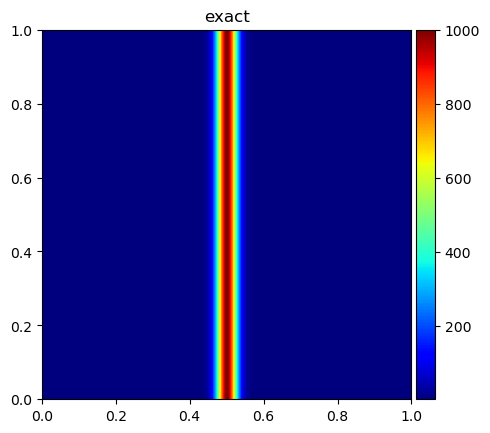

In [10]:
    fig = plt.figure()  #定义新的三维坐标轴
    ax = plt.axes(projection='3d')
    #U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(res, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='1')
    ax.set_title('exact')
    #左边的色差图
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    plt.show() 

In [11]:
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

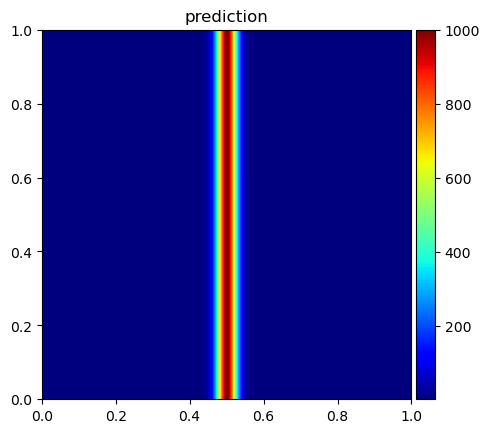

In [12]:
    fig = plt.figure()  #定义新的三维坐标轴
    ax = plt.axes(projection='3d')

    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='1')
    ax.set_title('prediction')
    #左边的色差图
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    plt.show() 

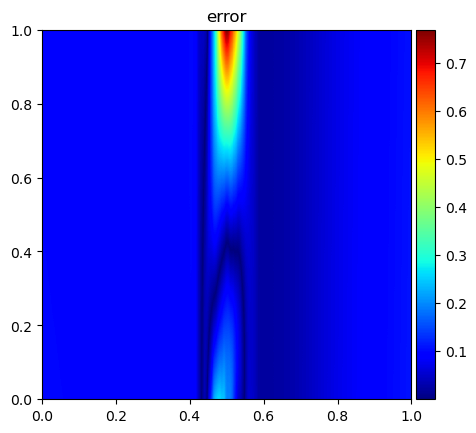

In [13]:
    fig = plt.figure()  #定义新的三维坐标轴
    ax = plt.axes(projection='3d')

    ax.axis('off')
    gs0 = gridspec.GridSpec(1, 2)
    ax = plt.subplot(gs0[:, :])
    h = ax.imshow(np.abs(U_pred.T-res), interpolation='nearest', cmap='jet', 
                  extent=[lb[1], ub[1], lb[0], ub[0]], 
                  origin='lower', aspect='1')
    ax.set_title('error')
    #左边的色差图
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    #plt.savefig('Waterasdes.jpg', dpi=500, bbox_inches='tight') # 解决图片不清晰，不完整的问题
    #plt.savefig('Anisotropic MMPINN2.pdf', bbox_inches='tight') 
    plt.show() 

In [14]:
scipy.io.savemat("uu.mat", {'u': u_pred})